In [1]:
#chamar os pacotes
import requests
from bs4 import BeautifulSoup

## Parte 1

Aqui vou acessar uma página de um fórum de torcedores do Palmeiras (Palmeiras todo dia) e pegar todos os tópicos a respeito de opiniões pós-jogo no ano de 2024.

In [2]:
#chamar o headers
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36"
}

In [3]:
#eu vi que as páginas de 2024 vão até o 10
paginas = []
for i in range(10):
  paginas.append(f'http://www.forumptd.com/index.php?/forum/17-f%C3%B3rum-palmeiras-todo-dia/page/{i}/&sortby=start_date&sortdirection=desc#google_vignette')

In [4]:
#mas a primeira tem uma nomenclatura diferente
paginas[0] = "http://www.forumptd.com/index.php?/forum/17-f%25C3%25B3rum-palmeiras-todo-dia/&sortby=start_date&sortdirection=desc"

In [5]:
import time #para não ser banido
import random
links = [] #vou salvar os links das paginas dos tópicos pós-jogo
for i in paginas:
  response = requests.get(i, headers=headers)
  soup = BeautifulSoup(response.text, "html.parser")
  bloco = soup.find_all('span',{'class':'ipsType_break ipsContained'}) #aqui estão as URLS
  for i in range(len(bloco)):
    acha = [a['href'] for a in bloco[i].find_all('a', href=True)]
    links.append(acha[0]) #pegar só a primeira
  tempo_espera = random.uniform(0, 0.01) #não ser banido
  time.sleep(tempo_espera)

links_fitrados = [item for item in links if 'p%C3%B3s-jogo' in item] #filtrar apenas o pós jogos

In [6]:
len(links_fitrados) ## 62 jogos

#exemplo da url
links_fitrados[0]

'http://www.forumptd.com/index.php?/topic/132503-palmeiras-x-fluminense-p%C3%B3s-jogo/'

## Parte 2

Agora vou extrair as opiniões dos tópicos de cada partida

Primeiramente, preciso pegar o todas as urls das páginas de cada tópico de pós-jogo, pois tem tópicos em mais páginas. Para isso, segue o exemplo:

In [7]:
response = requests.get( 'http://www.forumptd.com/index.php?/topic/132503-palmeiras-x-fluminense-p%C3%B3s-jogo/' , headers=headers)
soup = BeautifulSoup(response.text, "html.parser")
urls = soup.find_all('li',{'class':'ipsPagination_page'}) #aqui estão as URLS

Pórem, percebi que temos dois blocos repetidos de urls, por isso vou percorrer somente um desses blocos.

In [8]:
#mostrar as urls
for i in range(int(len(urls)/2)):
    print([a['href'] for a in urls[i].find_all('a', href=True)])

['http://www.forumptd.com/index.php?/topic/132503-palmeiras-x-fluminense-p%C3%B3s-jogo/#comments']
['http://www.forumptd.com/index.php?/topic/132503-palmeiras-x-fluminense-p%C3%B3s-jogo/page/2/#comments']
['http://www.forumptd.com/index.php?/topic/132503-palmeiras-x-fluminense-p%C3%B3s-jogo/page/3/#comments']
['http://www.forumptd.com/index.php?/topic/132503-palmeiras-x-fluminense-p%C3%B3s-jogo/page/4/#comments']
['http://www.forumptd.com/index.php?/topic/132503-palmeiras-x-fluminense-p%C3%B3s-jogo/page/5/#comments']
['http://www.forumptd.com/index.php?/topic/132503-palmeiras-x-fluminense-p%C3%B3s-jogo/page/6/#comments']


Agora, partindo para extrair as opiniões de cada página de cada pós jogo, segue o exemplo:

In [9]:
response = requests.get('http://www.forumptd.com/index.php?/topic/131668-palmeiras-x-corinthians-p%C3%B3s-jogo/' , headers=headers)
soup = BeautifulSoup(response.text, "html.parser")
opns = soup.find('script', type='application/ld+json') #elas estão em um json

In [10]:
import json #vou usar um json para acessar então
if opns:
    json_data = json.loads(opns.string)
    print(json_data)

{'name': 'Palmeiras x Corinthians - Pós-jogo', 'headline': 'Palmeiras x Corinthians - Pós-jogo', 'text': 'Comente\xa0aqui:\n \n\n\n\t- Atuação do\xa0time + atuações individuais \n\t- Atuação do técnico \n\t- Atuação da arbitragem\n \n\n\n\tO tópico será aberto às 21h52 e será\xa0fechado 1 hora antes do próximo jogo (18h00 de 04/7).\n ', 'dateCreated': '2024-07-01T15:31:04+0000', 'datePublished': '2024-07-01T15:31:04+0000', 'pageStart': 1, 'pageEnd': 9, 'image': 'http://www.forumptd.com/uploads/monthly_2019_03/menor.thumb.jpg.b20ebb50ae8cc43b0b07b72eff926ef4.jpg', 'author': {'url': 'http://www.forumptd.com/index.php?/profile/2-eduardo-luiz/'}, 'interactionStatistic': [{'@type': 'InteractionCounter', 'interactionType': 'http://schema.org/ViewAction', 'userInteractionCount': 6874}, {'@type': 'InteractionCounter', 'interactionType': 'http://schema.org/CommentAction', 'userInteractionCount': 128}, {'@type': 'InteractionCounter', 'interactionType': 'http://schema.org/FollowAction', 'userInte

In [11]:
from datetime import datetime

#já vi que vou ter que limpar o texto que está em html

import html
import re

def limpar(string):
    string = html.unescape(string)
    string = re.sub(r'[\n\t]+', ' ', string)
    string = re.sub(r'\s+', ' ', string).strip()
    return string

#Além disso, vou substituir algumas abreviações para facilitar a análise
ab = {
    'pal': 'palmeiras',
    "q": "que",
    "n": "não",
    "vc": "você",
    "tb": "também",
    "pq": "porque",
    "td": "tudo",
    "dps": "depois",
    "mlk": "menino",
    "qdo": "quando",
    "pq": "porque",
    "vdd": "verdade",
    "qnt": "quanto",
    "blz": "beleza",
    "pf": "por favor",
}

def abrev(texto):
    for gíria, correção in ab.items():
        texto = re.sub(rf"\b{gíria}\b", correção, texto, flags=re.IGNORECASE)
    return texto

In [12]:
aa = [] #salvar as opiniões
bb = [] #salvar a data
for i in range(len(json_data['comment'])):
    texto_limpo = limpar(json_data['comment'][i]['text'])
    texto_limpo = abrev(texto_limpo)
    aa.append(texto_limpo)
    data = datetime.strptime(json_data['comment'][re.I]['dateCreated'], "%Y-%m-%dT%H:%M:%S%z")
    data_formatada = data.strftime("%m/%Y")
    bb.append(data_formatada)

In [ ]:
aa

['Comente aqui: - Atuação do time + atuações individuais - Atuação do técnico - Atuação da arbitragem O tópico será aberto às 21h52 e será fechado 1 hora antes do próximo jogo (18h00 de 04/7).',
 'Avanti Palestra!!!!!!!!! 💚🐷🐽',
 'Terminamos o jogo com 3 laterais direitos e 2 esquerdos em campo! Recorde batido. Gyai chegando! 😂 3 pontos, afundamos os lixos na lama! Avanti!!’',
 'Clássico não se joga, se ganha. Mais 3 pontos pra conta! A molecada deu conta do recado, Naves e Vitor Reis, foram bem demais! Chupa gambazada maldita! 🐷👊🏻',
 'Partidaca do Vitor e do Naves!',
 'JP Sampaio, você é o cara! Que base maravilhosa! Que molecada firme! Vitor Reis estrear com gol e uma bela partida. Teve até dobra dupla de lateral e lateral (mais) improvisado! E o Veiga foi expulso, poderia comprometer, mas acho que eu faria o mesmo. Ninguém bota dedo na cara dos meus!',
 'Afundou essa praga de time da marginal sem número. Isso é o que interessa!',
 'O sub20 deu conta. Na próxima a gente testa o 17. Vi

## Parte 3

Agora sim, vou fazer um laço para salvar tudo de uma vez em alguns arquivos json.

In [13]:
urls_tot = []
for i in links_fitrados:
    #pegara as urls
    response = requests.get(i, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    urls = soup.find_all('li',{'class':'ipsPagination_page'})
    tempo_espera = random.uniform(0, 0.01) #não ser banido
    time.sleep(tempo_espera)
    urls_pag = []
    for j in range(int(len(urls)/2)):
        #pegar as urls das páginas
        urls_pag.append([a['href'] for a in urls[j].find_all('a', href=True)])
    urls_tot.append(urls_pag)

Certo, agora tenho uma lista com todas as urls necessárias.

In [16]:
jogos_all = [] #vou aproveitar e guardar o nome dos jogos
jogos_dir = [] #e o diretório
jogos_data = [] #e a data
for jj in range(len(urls_tot)):
    dic = {}
    aa = [] #salvar as opiniões
    for i in range(len(urls_tot[jj])):
        response = requests.get(urls_tot[jj][i][0] , headers=headers)
        soup = BeautifulSoup(response.text, "html.parser")
        opns = soup.find('script', type='application/ld+json') #elas estão em um json
        tempo_espera = random.uniform(0, 0.01) #não ser banido
        time.sleep(tempo_espera)
        if opns:
            json_data = json.loads(opns.string)
        for i in range(len(json_data['comment'])):
            texto_limpo = limpar(json_data['comment'][i]['text'])
            texto_limpo = abrev(texto_limpo)
            aa.append(texto_limpo)
            try:
                data = datetime.strptime(json_data['comment'][re.I]['dateCreated'], "%Y-%m-%dT%H:%M:%S%z")
            except:
                pass
            data_formatada = data.strftime("%m/%Y")
    ##salvar o id dos jogos
    import urllib.parse
    s = urls_tot[jj][0][0]
    partes = s.split('-')
    ss = '-'.join(partes[1:4])
    data_formatada = data_formatada.replace('/', '')
    game =  ss + '-' + data_formatada
    game = urllib.parse.unquote(game)
    jogos_all.append(game)
    jogos_dir.append(game + '.json')
    jogos_data.append(data_formatada)
    dic['jogo'] = game
    dic['data'] = data_formatada #tirar a barra para não dar conflito de diretótio
    dic['opinioes'] = aa[1:] #tirar o início do tópico
    with open(game + '.json', 'w') as arquivo: #salvar em json
        json.dump(dic, arquivo, indent=4)

## Parte 4

Agora, irei fazer uma análise de sentimento das opiniões dos torcedores em cada partida a fim de quantificar o contentamento ou descontentamento com a partida em questão. Para isso, usarei o pacote LeIA, uma adaptação do pacote VADER, com adaptação para textos em português. A análise atribui uma nota de -1 a 1, que quanto mais próximo de 1 o sentimento é positivo, e negativo ao aproximar de -1.

A ideia é calcular esse valor para cada comentário e calcular a média deles para quantificar o contentamento em cada um dos jogos.

Por fim, iremos verificar quais jogos foram os "melhores" de acordo com a torcida, além dos piores. Ainda, iremos plotar um gráfico de linhas com o valor das métricas em ordem cronológica ao longo do ano para visualizar o comportamento.

In [23]:
import pandas as pd
data = pd.DataFrame({'jogo': jogos_all, 'diretorio': jogos_dir, 'data': jogos_data})
#tirar a primeira linha que está duplicada
data = data.drop(index=0).reset_index(drop=True)

In [24]:
data

,jogo,diretorio,data
0,palmeiras-x-fluminense-122024,palmeiras-x-fluminense-122024.json,122024
1,cruzeiro-x-palmeiras-122024,cruzeiro-x-palmeiras-122024.json,122024
2,palmeiras-x-botafogo-112024,palmeiras-x-botafogo-112024.json,112024
3,atlético-go-x-112024,atlético-go-x-112024.json,112024
4,bahia-x-palmeiras-112024,bahia-x-palmeiras-112024.json,112024
...,...,...,...
56,palmeiras-x-mirassol-022024,palmeiras-x-mirassol-022024.json,022024
57,palmeiras-x-corinthians-022024,palmeiras-x-corinthians-022024.json,022024
58,são-bernardo-x-022024,são-bernardo-x-022024.json,022024
59,palmeiras-x-ituano-022024,palmeiras-x-ituano-022024.json,022024


In [21]:
pip install LeIA-br

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.0/130.0 kB 6.2 MB/s eta 0:00:00


In [22]:
from LeIA import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [27]:
sentimentos = [] #salvar a análise de sentimentos de cada jogo
for j in range(data.shape[0]):
    compound_score = 0
    diretorio = '/content/' + data['diretorio'][j]
    with open(diretorio, 'r', encoding='utf-8') as arquivo:
        dados = json.load(arquivo)
    for i in range(len(dados['opinioes'])):
        sentiment = analyzer.polarity_scores(dados['opinioes'][i])
        compound_score += sentiment['compound']
    sentimentos.append(compound_score/len(dados['opinioes'])) #tirar a média de todas as opiniões

In [31]:
data['sentimentos'] = sentimentos

In [32]:
data

,jogo,diretorio,data,sentimentos
0,palmeiras-x-fluminense-122024,palmeiras-x-fluminense-122024.json,122024,-0.232522
1,cruzeiro-x-palmeiras-122024,cruzeiro-x-palmeiras-122024.json,122024,-0.029487
2,palmeiras-x-botafogo-112024,palmeiras-x-botafogo-112024.json,112024,-0.249251
3,atlético-go-x-112024,atlético-go-x-112024.json,112024,-0.081573
4,bahia-x-palmeiras-112024,bahia-x-palmeiras-112024.json,112024,-0.049989
...,...,...,...,...
56,palmeiras-x-mirassol-022024,palmeiras-x-mirassol-022024.json,022024,-0.000795
57,palmeiras-x-corinthians-022024,palmeiras-x-corinthians-022024.json,022024,-0.303917
58,são-bernardo-x-022024,são-bernardo-x-022024.json,022024,0.041796
59,palmeiras-x-ituano-022024,palmeiras-x-ituano-022024.json,022024,-0.236302


In [41]:
## 5 piores avaliações
data.sort_values(by=['sentimentos']).head(5)

,jogo,diretorio,data,sentimentos
22,fluminense-x-palmeiras-072024,fluminense-x-palmeiras-072024.json,072024,-0.401516
60,palmeiras-x-são-022024,palmeiras-x-são-022024.json,022024,-0.336275
54,são-paulo-x-032024,são-paulo-x-032024.json,032024,-0.334825
18,palmeiras-x-flamengo-082024,palmeiras-x-flamengo-082024.json,082024,-0.323919
29,fortaleza-x-palmeiras-062024,fortaleza-x-palmeiras-062024.json,062024,-0.306875


Para identificar uns dos objetivos, iremos ver quais foram as piores e as melhores avaliações.

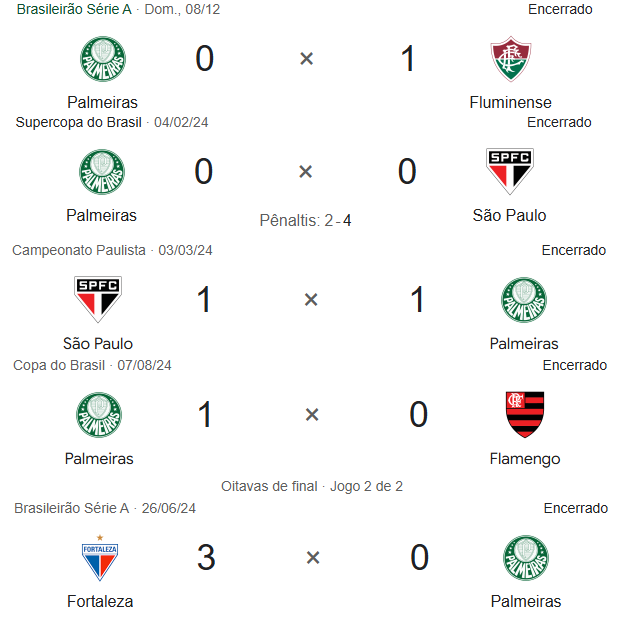

In [42]:
from IPython.display import Image
Image('/content/odiados.png')

In [40]:
## 5 melhores avaliações
data.sort_values(by=['sentimentos'], ascending=False).head(5)

,jogo,diretorio,data,sentimentos
30,palmeiras-x-juventude-062024,palmeiras-x-juventude-062024.json,062024,0.243280
52,palmeiras-x-ponte-032024,palmeiras-x-ponte-032024.json,032024,0.214594
26,palmeiras-x-bahia-072024,palmeiras-x-bahia-072024.json,072024,0.196200
32,atlético-mg-x-062024,atlético-mg-x-062024.json,062024,0.159445
48,palmeiras-x-santos-042024,palmeiras-x-santos-042024.json,042024,0.098184


Segundo o ID, os melhores jogos segundo as opiniões da torcida foram:



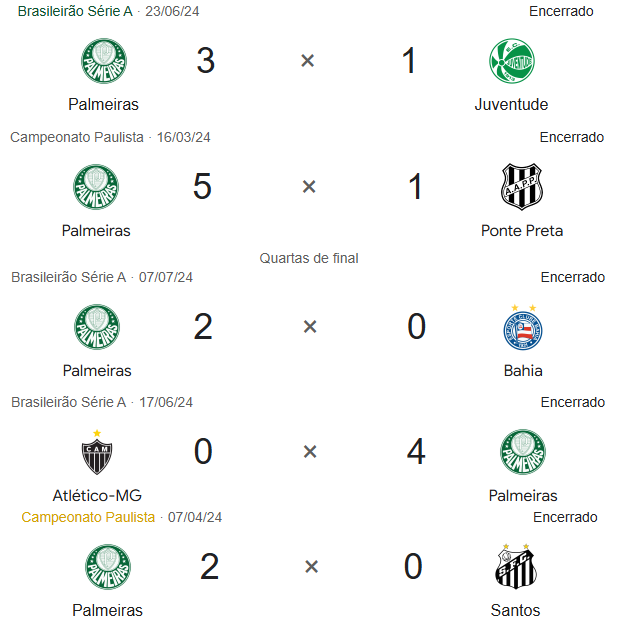

In [43]:
Image('/content/amados.png')

De fato a análise refletiu com o que se esperava, com derrotas tendo o conteúdo mais negativa das opiniões (mesmo na vitória sobre o Flamengo, o Palmeiras foi eliminado), e vitórias com opiniões mais positivas.

Por curiosidade, vamos ver alguns exemplos de comentários do pior e do melhor jogo:

In [68]:
#pior jogo:
with open('/content/fluminense-x-palmeiras-072024.json', 'r', encoding='utf-8') as arquivo:
    dados = json.load(arquivo)

#comentário
dados['opinioes'][0]

'Destruiu o time quando tirou Veiga e Aníbal numa só tacada.'

In [46]:
#comentário
dados['opinioes'][1]

'Esperar algo diferente quando tem em campo Marcos Rocha, Menino e Zé Preguiça e Rony é loucura. Esses jogadores sao a cara da derrota! Abel tem que colocar o Gyai para jogador, o Romulo não pode ser reserva do Menino, Duvido que o Luighi jogue menos que o Rony. Abel e seus queridinhos, vão todas tomar um suco de caju! Sem açúcar!'

In [69]:
#comentário
dados['opinioes'][2]

'PERDEMOS PARA A PORR4 DO LANTERNA DO CAMPEONATO, TIME DE APOSENTADO!! VERGONHOSO, SIMPLES ASSIM, PARTIDA NOJENTA, SE JOGAR ASSIM OS MATA MATA ESQUECE! ENFIA ESSA PORR4 DE GABRIEL MENINO E DESSE MARCOS ROCHA NO ** NÃO CONSEGUE JOGAR CONTRA ESSE TIME DE APOSENTADOS, VAI JOGAR CONTRA FLAMIDIA E BOSTAFOGO? JOGA ASSIM QUE O ANO ACABA LOGO LOGO'

In [49]:
#pior jogo:
with open('/content/palmeiras-x-juventude-062024.json', 'r', encoding='utf-8') as arquivo:
    dados = json.load(arquivo)

#comentário
dados['opinioes'][0]

'hoje o juventude dificultou no 1 tempo. estevão além de não ter apoio do rocha, ainda teve marcação dobrada. mas o time está forte, na hora que o time "titular" está em campo o jogo melhora. Anibal faz diferença nesse meio de campo.'

In [52]:
#comentário
dados['opinioes'][3]

'Bom jogo, tirando a falha no latereio e alguns espaços dados, jogo foi controlado até. O juventude não é bobo, foi um bom resultado. +3 pontos avanti!'

In [51]:
#comentário
dados['opinioes'][2]

'Bom jogo, dessa vez com muitos desfalques. Vi muita gente incomodada com o primeiro tempo, mas esse era um jogo difícil que necessitava de muita paciência e troca de bola. O adversário optou por uma postura muito defensiva e antijogo, permitido pelo árbitro. Veiga mais uma vez muito bem, Estêvão decisivo. Flaco com participação direta em dois gols, mas tem quem não goste. A nota negativa fica pro Murilo, que entregou o gol e depois ainda cedeu uma grande chance pro adversário. Só mais um jogo pra fechar um junho com 100% de aproveitamento.'

De fato, condiz com o que foi visto na análise de sentimento.

Partindo para uma última análise, vamos verificar como estava as opiniões da torcida ao longo do ano:

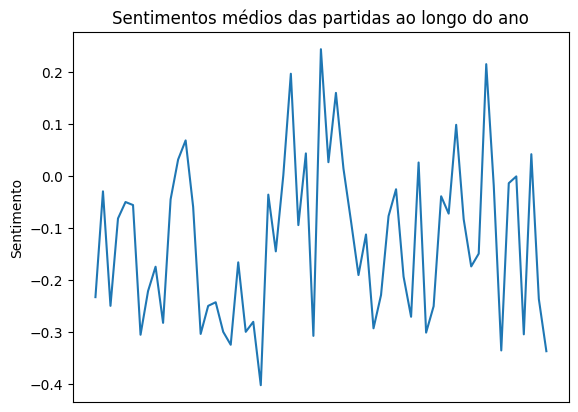

In [56]:
import matplotlib.pyplot as plt
plt.plot(data['sentimentos'][::1]) #inverter para ficar na ordem cronologica
plt.gca().set_aspect('auto', adjustable='box')
plt.xticks([]) #tirar os numeros do eixo y
plt.title('Sentimentos médios das partidas ao longo do ano')
plt.ylabel('Sentimento')
plt.show()

Como temos muitos picos e vales, uma média móvel pode ser melhor para capturar o comportamento.

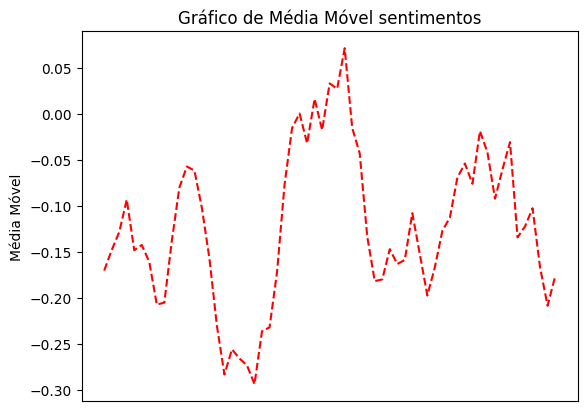

In [70]:
mm = data['sentimentos'][::1].rolling(window=5, center=True, min_periods=1).mean() #janela de 2 para trás e 2 frente
plt.plot(mm, label='Média Móvel', linestyle='--', color='red')

# Adicionando título e rótulos
plt.title('Gráfico de Média Móvel sentimentos')
plt.ylabel('Média Móvel')
plt.xticks([]) #tirar os numeros do eixo y

# Exibindo o gráfico
plt.show()

Pela análise do gráfico, temos uma queda no contentamento da torcidade com os jogos no primeiro trimestre do ano, seguido de um grande pico de contentamento após isso, atingindo o valor máximo da análise de sentimentos no meio do ano. Após isso, houve novamente uma queda busca, seguindo de um leve aumento seguido de uma queda até o final do ano.



Marcando os piores jogos:

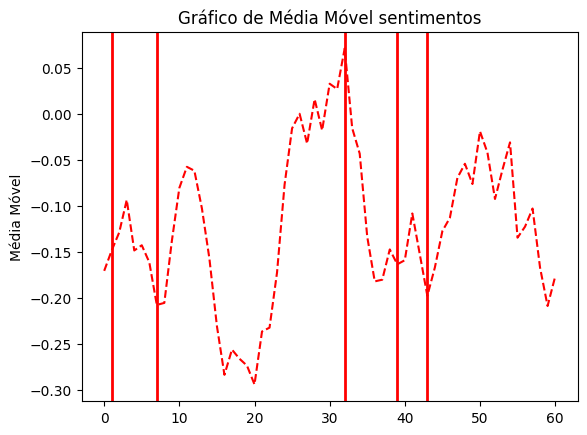

In [71]:
mm = data['sentimentos'][::1].rolling(window=5, center=True, min_periods=1).mean() #janela de 2 para trás e 2 frente
plt.plot(mm, label='Média Móvel', linestyle='--', color='red')

# Adicionando título e rótulos
plt.title('Gráfico de Média Móvel sentimentos')
plt.ylabel('Média Móvel')

plt.axvline(x=61-22, color='red', linestyle='-', linewidth=2)
plt.axvline(x=61-60, color='red', linestyle='-', linewidth=2)
plt.axvline(x=61-54, color='red', linestyle='-', linewidth=2)
plt.axvline(x=61-18, color='red', linestyle='-', linewidth=2)
plt.axvline(x=61-29, color='red', linestyle='-', linewidth=2)


# Exibindo o gráfico
plt.show()



Podemos verificar que 2 dos piores jogos se localizam no início do ano. Um deles ainda está no maior pico, e dois deles após a queda deste pico. Impressiona que nenhum deles está no maior vale do gráfico.

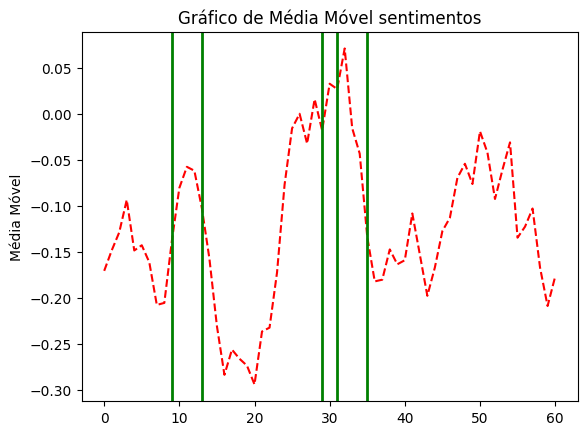

In [72]:
mm = data['sentimentos'][::1].rolling(window=5, center=True, min_periods=1).mean() #janela de 2 para trás e 2 frente
plt.plot(mm, label='Média Móvel', linestyle='--', color='red')

# Adicionando título e rótulos
plt.title('Gráfico de Média Móvel sentimentos')
plt.ylabel('Média Móvel')

plt.axvline(x=61-30, color='green', linestyle='-', linewidth=2)
plt.axvline(x=61-52, color='green', linestyle='-', linewidth=2)
plt.axvline(x=61-26, color='green', linestyle='-', linewidth=2)
plt.axvline(x=61-32, color='green', linestyle='-', linewidth=2)
plt.axvline(x=61-48, color='green', linestyle='-', linewidth=2)


# Exibindo o gráfico
plt.show()

Com relação ao melhores jogos, dois deles estão em um pequeno pico após o início do ano, e o restante no maior pico presente no gráfico.

Conclusão: com as análises, foi possível identificar os 5 jogos onde a opinião da torcida foi mais positiva de acordo com a análise de sentimentos, além dos piores também. Pode-se ressaltar que as análises refletem os resultados dos jogos na "vida real". Ainda, foi possível verificar o comportamento da satisfação dos torcedores ao longo do ano, observando os vales e picos dos sentimentos, além de onde os melhores e piores anos se enquadram nessas análises.